<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/DeepLearning_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#目标检测
&emsp;&emsp;在图像分类任务中，我们假设图像中只有⼀个主要物体对象，我们只关注如何识别其类别。然而，很多时候图像⾥有多个我们感兴趣的⽬标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。在计算机视觉⾥，我们将这类任务称为⽬标检测（object detection）或物体检测。

In [2]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.2 MB/s 


##对象的位置

In [ ]:
%matplotlib inline
import torch
from d2l import torch  as d2l

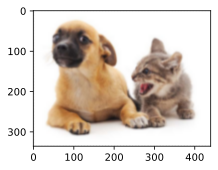

In [ ]:
d2l.set_figsize()
img = d2l.plt.imread('/home/catdog.png')
d2l.plt.imshow(img)

##边界框
&emsp;&emsp;在⽬标检测中，通常使⽤边界框（bounding box）来描述对象的空间位置。边界框是矩形的，由矩形左⻆的 x 和 y 坐标以及右下⻆的坐标决定。另⼀种常⽤的边界框表⽰⽅法是边界框中⼼的 (x, y) 轴坐标以及框的宽度和⾼度。

In [ ]:
def box_corner_to_center(boxes):
  """从（左上，右下）转换到（中间，宽度，高度）"""
  x1,y1,x2,y2 = boxes[:,0],boxes[:,1],boxes[:,2],boxes[:,3]
  cx = (x1+x2) / 2
  cy = (y1+y2) / 2
  w = x2-x1
  h = y2-y1
  boxes = torch.stack((cx,cy,w,h),axis=-1)
  return boxes

def box_center_to_corner(boxes):
  """从（中间，宽度，高度）转换到（左上，右下）"""
  cx,cy,w,h = boxes[:,0],boxes[:,1],boxes[:,2],boxes[:,3]
  x1 = cx - 0.5 * w
  y1 = cy - 0.5 * h
  x2 = cx + 0.5 * w
  y2 = cy + 0.5 * h
  boxes = torch.stack((x1,y1,x2,y2),axis=-1)
  return boxes

In [ ]:
dog_bbox, cat_bbox = [30.0, 22.5, 235.0, 305.0], [245.0, 56.0, 400.0, 295.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [ ]:
def bbox_to_rect(bbox, color):
# 将边界框 (左上x, 左上y, 右下x, 右下y) 格式转换成 matplotlib 格式：
# ((左上x, 左上y), 宽, ⾼)
  return d2l.plt.Rectangle(
    xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
    fill=False, edgecolor=color, linewidth=2)

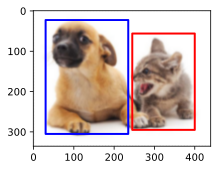

In [ ]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

##小结
* ⽬标检测不仅可以识别图像中所有感兴趣的物体，还能识别它们的位置，该位置通常由矩形边界框表
⽰。
* 我们可以在两种常⽤的边界框表⽰（中间，宽度，⾼度）和（左上，右下）坐标之间进⾏转换。

##目标检测数据集

In [6]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l
#下载数据集
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL+'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [ ]:
#读取数据集
def read_data_bananas(is_train=True):
  """读取香蕉检测数据集中的图像和标签"""
  data_dir = d2l.download_extract('banana-detection')
  csv_fname = os.path.join(data_dir,'bananas_train'if is_train else 'bananas_val','label.csv')
  csv_data = pd.read_csv(csv_fname)
  csv_data = csv_data.set_index('img_name')
  images,targets = [],[]
  for img_name,target in csv_data.iterrows():
    images.append(torchvision.io.read_image(
        os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')))
    targets.append(list(target))
  return images,torch.tensor(targets).unsqueeze(1) / 256

In [ ]:
class BananasDataset(torch.utils.data.Dataset):
  """⼀个⽤于加载⾹蕉检测数据集的⾃定义数据集。"""
  def __init__(self, is_train):
    self.features, self.labels = read_data_bananas(is_train)
    print('read ' + str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))
  def __getitem__(self, idx):
    return (self.features[idx].float(), self.labels[idx])
  def __len__(self):
    return len(self.features)

In [ ]:
def load_data_bananas(batch_size):
  """加载⾹蕉检测数据集。"""
  train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),batch_size, shuffle=True)
  val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),batch_size)
  return train_iter, val_iter

In [ ]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

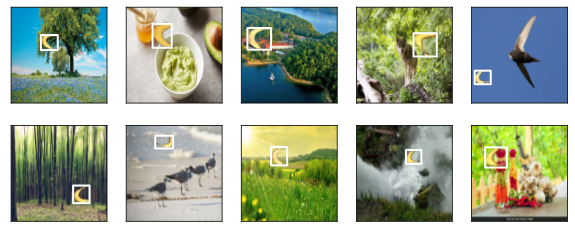

In [ ]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
  d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

##小结
* 我们收集的⾹蕉检测数据集可⽤于演⽰⽬标检测模型。
* ⽤于⽬标检测的数据加载与图像分类的数据加载类似。但是，在⽬标检测中，标签还包含真实边界框的信息，它不出现在图像分类中。

#锚框(这节好多不懂啊啊啊啊啊啊)
* 一类目标检测算法是基于锚框的
>* 提出多个被称为锚框的区域（边缘框）
>* 预测每个锚框里是否含有关注的物体
>* 如果是，预测从这个锚框到真实边缘框的偏移



In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)

>&emsp;&emsp;锚框的宽度和高度分别是$ws\sqrt{r}$和$\frac{hs}{\sqrt{r}}$,当中心位置给定时，已知宽和高的锚框是确定的。在实践中，我们只考虑包含$s_1$或$r_1$的组合：$(s_1,r_1),(s_1,r_2),...,(s_1,r_m),(s_2,r_1),(s_3,r_1),...,(s_n,r_1)$.一共n+m-1个锚框. 

In [ ]:
#生成多个锚框，指定输入图像、尺度列表和宽高比列表，然后此函数将返回所有的锚框,他是以每一个像素为中心生成的n个不一样的锚框
def multibox_prior(data,sizes,ratios):
  """生成以每个像素为中心具有不同形状的锚框"""
  in_height,in_width = data.shape[-2:]
  device,num_sizes,num_ratios = data.device,len(sizes),len(ratios)
  boxes_per_pixel = (num_sizes + num_ratios - 1)#锚框个数
  size_tensor = torch.tensor(sizes,device=device)
  ratio_tensor = torch.tensor(ratios,device=device)
  #为了将锚点移动到像素的中心，需要设置偏移量。
  #因为一个像素的的高为1且宽为1，我们选择偏移我们的中心0.5
  offset_h, offset_w = 0.5, 0.5
  steps_h = 1.0 / in_height # Scaled steps in y axis
  steps_w = 1.0 / in_width # Scaled steps in x axis

  #生成锚框的所有中心点
  center_h = (torch.arange(in_height,device=device)+offset_h) * steps_h
  center_w = (torch.arange(in_width,device=device)+offset_h) * steps_w
  shift_y,shift_x = torch.meshgrid(center_h,center_w)
  shift_y,shift_x = shift_y.reshape(-1),shift_x.reshape(-1)

  #生成boxes_per_pixel个高和宽，用于创建锚框的四角左边（xmin，xmax，ymin，ymax）
  w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width # Handle rectangular inputs
  h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),sizes[0] / torch.sqrt(ratio_tensor[1:])))
  # 除以2来获得半高和半宽
  anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
  # 每个中心点都将有“boxes_per_pixel”个锚框，
  # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
  out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1).repeat_interleave(boxes_per_pixel, dim=0)
  output = out_grid + anchor_manipulations
  return output.unsqueeze(0)

In [ ]:
img = d2l.plt.imread('/home/catdog.png')
h, w = img.shape[:2]
print(h, w)
X = torch.rand(size=(1, 3, h, w))#批量大小无关,只要形状一样,生成锚框都一样
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

336 440


torch.Size([1, 739200, 4])

In [ ]:
boxes = Y.reshape(h, w, 5, 4)
boxes[100, 100, 0, :]

tensor([-0.06, -0.08,  0.51,  0.67])

In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
  """显示所有边界框。"""
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj
  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

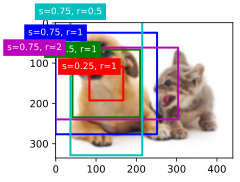

In [ ]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[150, 125, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2','s=0.75, r=0.5'])

## IoU-交并比计算标准

* IoU用来计算两个框之间的相似度，0表示无重叠，1表示重合
* 两个边界框相交面积与相并面积之比

![IoU](http://pan.anderd.com/download/615a68bd9ef575003fb20ac2)

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$J(A,B)=\frac{|A\bigcap B|}{|A\bigcup B|}$



In [ ]:
#实现交并比函数
def box_iou(boxes1,boxes2):#boxes1,左上x,左上y,右下x,右下y
  """计算两个锚框或边界框列表中成对的交并比。"""
  box_area = lambda boxes:((boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1]))
  areas1 = box_area(boxes1)
  areas2 = box_area(boxes2)
  #用了广播机制,使得最后的结果shape是(no. of boxes1, no. of boxes2, 2)
  inter_upperlefts = torch.max(boxes1[:,None,:2],boxes2[:,:2])#取出boxes1和boxes2交集的左上坐标
  inter_lowerrights = torch.min(boxes1[:,None,2:],boxes2[:,2:])#取出boxes1和boxes2交集的右下坐标
  inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
  inter_areas = inters[:,:,0]*inters[:,:,1]
  union_areas = areas1[:,None]+areas2-inter_areas
  return inter_areas/union_areas

>pytoch.clamp(input,min,max,out=None)函数将输入input张量每个元素的夹紧到区间 [min,max][min,max]，并返回结果到一个新张量.

$y_i=\left\{\begin{matrix}
 min, x_i <  min \\ 
 x_i,  min\leqslant   x_i\leqslant   max \\ 
 max,  x_i  >  max 
\end{matrix}\right.$



## 赋予锚框标号
* 每一个锚框是一个训练样本
* 最接近的真实边界框标号分配给锚框
###步骤
>1. 在矩阵X中找到最大的元素，并将它的行索引和列索引分别表示为$i_1$和$j_1$。然后将真实边界框$B_{j1}$分配给锚框$A_{i1}$。这很直观，因为$A_{i1}$和$B_{j1}$是所有锚框和真实边界框配对中最相近的。在第一个分配完成后，丢弃矩阵中$i_1^{th}$行和$j_1^{th}$列中的所有元素。
> 2. 在矩阵X中找到剩余元素中最大的元素，并将它的行索引和列索引分别表示为$i_2$和$j_2$。我们将真实边界框$B_{j2}$分配给锚框$A_{i2}$，并丢弃矩阵中$i_2^{th}$行和$j_2^{th}$列中的所有元素。
>3. 此时，矩阵X中两行和两列中的元素已被丢弃。我们继续，直到丢弃掉矩阵X中$n_b$列中的所有元素。此时，我们已经为这$n_b$个锚框各自分配了一个真实边界框。
>4. 只遍历剩下的$n_a$−$n_b$个锚框。例如，给定任何锚框$A_i$，在矩阵X的第$i^th$行中找到与$A_i$的IoU最大的真实边界框$B_j$，只有当此IoU大于预定义的阈值时，才将$B_j$分配给$A_i$。



In [ ]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [ ]:
# label Offset
# 为了让offset更容易拟合，要使offset更加均匀的分布。
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [ ]:
def multibox_target(anchors, labels):
   batch_size, anchors = labels.shape[0], anchors.squeeze(0)
   batch_offset, batch_mask, batch_class_labels = [], [], []
   device, num_anchors = anchors.device, anchors.shape[0]
   for i in range(batch_size):
#         label 第二维为gt bbox， 第三维为class + xmin,ymin,xmax,ymax
       label = labels[i, :, :]
       anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors,
                                                device)
       bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
           1, 4)
       # Initialize class labels and assigned bounding box coordinates with
       # zeros
       class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                  device=device)
       assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                 device=device)
       # Label classes of anchor boxes using their assigned ground-truth
       # bounding boxes. If an anchor box is not assigned any, we label its
       # class as background (the value remains zero)  背景为0， 其他的class 依次+1
       indices_true = torch.nonzero(anchors_bbox_map >= 0)
       bb_idx = anchors_bbox_map[indices_true]
       class_labels[indices_true] = label[bb_idx, 0].long() + 1
       assigned_bb[indices_true] = label[bb_idx, 1:]
       # Offset transformation
       offset = offset_boxes(anchors, assigned_bb) * bbox_mask
       batch_offset.append(offset.reshape(-1))
       batch_mask.append(bbox_mask.reshape(-1))
       batch_class_labels.append(class_labels)
   bbox_offset = torch.stack(batch_offset)
   bbox_mask = torch.stack(batch_mask)
   class_labels = torch.stack(batch_class_labels)
   return (bbox_offset, bbox_mask, class_labels)

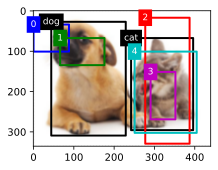

In [ ]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

##使用非极大值抑制预测边界框

> * 每个锚框预测一个边缘框
> * NMS可以合并相似的预测
 * 选中是非背景类的最大预测值
 * 去掉所有其他和他IoU值大于$\theta$的预测
 * 重复上述过程直到所有预测要么被选中，要么被去掉

In [ ]:
# 根据预测的offset 调整预测的bbox
def offset_inverse(anchors, offset_preds):
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [ ]:
# 将所有非背景类的bbox按照confidence降序排列，开始NMS
def nms(boxes, scores, iou_threshold):
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [ ]:
# apply non-maximum suppression to predicting bounding boxes
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)  # ???????????????????
#     print('anchors', anchors.shape)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred, anchor = cls_probs[i], offset_preds[i].reshape(-1, 4), anchors[i]
#         print('cls_prob', cls_prob.shape)
#         print('offset_pred', offset_pred.shape)
        conf, class_id = torch.max(cls_prob[1:], 0)   # 获得的class id 从0 开始
        predicted_bb = offset_inverse(anchor, offset_pred)  # 经offset修正后的bbox
        keep = nms(predicted_bb, conf, nms_threshold)     # 经nms后保留下来的bbox
        
        # 寻找non-keep， 并将类别设为background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        class_id[non_keep] = -1
        
        # 将keep的放在前面，将non_keep的放在后面
        all_id_sorted = torch.cat((keep, non_keep))
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        
        #将conf < pos_threshold的bbox,设置为背景，-1
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1), conf.unsqueeze(1), predicted_bb), dim=1)  # 在anchor的那一维度cat
        out.append(pred_info)
    return torch.stack(out)

In [ ]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted background likelihood 
                          [0.9, 0.8, 0.7, 0.1],  # Predicted dog likelihood 
                          [0.1, 0.2, 0.3, 0.9]])  # Predicted cat likelihood


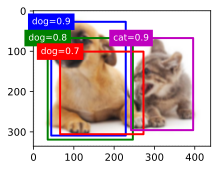

In [ ]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])


In [ ]:
output = multibox_detection(cls_probs.unsqueeze(dim=0).repeat(2, 1, 1),offset_preds.unsqueeze(dim=0).repeat(2, 1),anchors.unsqueeze(dim=0).repeat(2, 1, 1), nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]],

        [[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

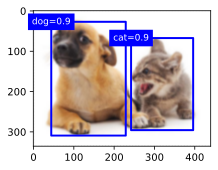

In [ ]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)


##小结
* 我们以图像的每个像素为中心生成不同形状的锚框。
* 交并比（IoU）也被称为Jaccard 指数，用于衡量两个边界框的相似性。它是相交面积与相并面积的比率。
* 在训练集中，我们需要给每个锚框两种类型的标签。一个是与锚框中目标检测的类别，另一个是锚框真实相对于边界框的偏移量。
* 在预测期间，我们可以使用非极大值抑制（NMS）来移除类似的预测边界框，从而简化输出。

#多尺度目标检测
&emsp;&emsp;我们用输入图像的每一个像素为中心，生成多个锚框，假如输入图片时561x728，且每个像素生成的锚框数是5，那么在检测时，我们需要对561x728x5个锚框进行检测，这个量太大了。多尺度检测缓解了这个问题。


In [11]:
#多尺度锚框
%matplotlib inline
import torch 
from d2l import torch as d2l

img = d2l.plt.imread('/home/catdog.png')
h,w=img.shape[:2]
h,w

(336, 440)

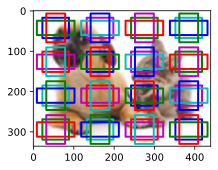

In [24]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)
    
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

> &emsp;&emsp;我们可以在输入图像中均匀采样一小部分像素，并以它们为中心生成锚框。此外，在不同尺度下，我们可以生成不同数量和不同大小的锚框。

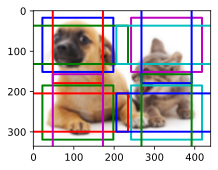

In [26]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])#将特征图的高度和宽度减小一半，然后使用较大的锚框来检测较大的目标。当尺度设置为0.4时，一些锚框将彼此重叠

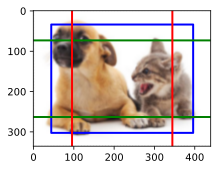

In [27]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])#将特征图的高度和宽度减小一半，然后将锚框的尺度增加到0.8。 此时，锚框的中心即是图像的中心。

##多尺度检测
&emsp;&emsp;生成了多尺度的锚框，我们就将使用它们来检测不同尺度下各种大小的目标.当不同层的特征图在输入图像上分别拥有不同大小的感受野时，它们可以用于检测不同大小的目标。靠近输出层的特征图单元具有更宽的感受野，这样它们就可以从输入图像中检测到较大的目标。(在下一节SSD中实现)

##小结
* 在多个尺度下，我们可以生成不同尺寸的锚框来检测不同尺寸的目标。
* 通过定义特征图的形状，我们可以决定任何图像上均匀采样的锚框的中心。
* 我们使用输入图像在某个感受野区域内的信息，来预测输入图像上与该区域位置相近的锚框类别和偏移量。

#单发多框检测（SSD）
##模型
![SSD](http://pan.anderd.com/download/615d98e176ce96003f86c94c)
>此模型主要由基础⽹络组成，其后是⼏个多尺度特征块。基本⽹络⽤于从输⼊图像中提取特征，因此它可以使⽤深度卷积神经⽹络。简而⾔之，通过多尺度特征块，单发多框检测⽣成不同⼤小的锚框，并通过预测边界框的类别和偏移量来检测⼤小不同的⽬标，因此这是⼀个多尺度⽬标检测模型。


In [9]:
#类别预测层，类别预测层使⽤⼀个保持输⼊⾼和宽的卷积层。这样⼀来，输出和输⼊在特征图宽和⾼上的空间坐标⼀⼀对应。
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

def cls_predictor(num_inputs,num_anchors,num_classes):
  return nn.Conv2d(num_inputs,num_anchors*(num_classes+1),kernel_size=3,padding=1)

输出特征图上（x、y）坐标的通道⾥包含了以输⼊特征图（x、y）坐标为中⼼生成的所有锚框的类别预测。每个单元（像素）为中⼼⽣成a个锚框，那么我们需要对hwa个锚框进⾏分类。因此输出通道数为a(q+1)，还有0类是背景。 

In [10]:
#边界框预测层,边界框预测层的设计与类别预测层的设计类似。唯⼀不同的是，这⾥需要为每个锚框预测4个偏移量，而不是q+1个类别。
def bbox_predictor(num_inputs,num_anchors):#与预测真实boundingbox框的offset，这里offset有4个值
  return nn.Conv2d(num_inputs,num_anchors*4,kernel_size=3,padding=1)

In [11]:
#连接多尺度的预测
def forward(x,block):
  return block(x)
Y1 = forward(torch.zeros((2,8,20,20)),cls_predictor(8,5,10))#结果是【2，55，20，20】，对20x20的图片做5x(10+1)次预测。
Y2 = forward(torch.zeros((2,16,10,10)),cls_predictor(16,3,10))
Y1.shape,Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

在不同的尺度下，特征图的形状或以同⼀单元为中⼼的锚框的数量可能会有所不同。因此,不同尺度下预测输出的形状可能会有所不同。其中任⼀输出的形状是（批量⼤小，通道数，⾼度，宽度）。


In [12]:
def flatten_pred(pred):
  return torch.flatten(pred.permute(0,2,3,1),start_dim=1)#permute函数将tensor的维度换位。

def concat_preds(preds):
  return torch.cat([flatten_pred(p) for p in preds],dim=1)

In [13]:
concat_preds([Y1,Y2]).shape

torch.Size([2, 25300])

In [14]:
#高宽减半块，为了在多个尺度下检测⽬标，我们在下⾯定义了⾼和宽减半块 down_sample_blk，该模块将输⼊特征图的⾼度和宽度减半。
def down_sample_blk(in_channels,out_channels):
  blk = []
  for _ in range(2):
    blk.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
    blk.append(nn.BatchNorm2d(out_channels))
    blk.append(nn.ReLU())
    in_channels = out_channels
  blk.append(nn.MaxPool2d((2)))#高宽减半
  return nn.Sequential(*blk)

In [15]:
#我们构建的⾼和宽减半块会更改输⼊通道的数量，并将输⼊特征图的⾼度和宽度减半
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 10, 10, 10])

In [16]:
#基本网络块，用于从输入图像中抽取特征
def base_net():
  blk = []
  num_filters = [3,16,32,64]
  for i in range(len(num_filters)-1):
    blk.append(down_sample_blk(num_filters[i],num_filters[i+1]))
  return nn.Sequential(*blk)
forward(torch.zeros((2,3,256,256)),base_net()).shape#256/2/2/2=32

torch.Size([2, 64, 32, 32])

In [17]:
#完整的模型，有5个模块组成，每个块⽣成的特征图既⽤于⽣成锚框，⼜⽤于预测这些锚框的类别和偏移量。五个尺度的目标检测
def get_blk(i):
  if i == 0:
    blk = base_net()
  elif i == 1:
    blk =down_sample_blk(64,128)
  elif i == 4:
    blk = nn.AdaptiveAvgPool2d((1,1))
  else:
    blk = down_sample_blk(128,128)#第三个和第四个在这，这里通道数保持不变
  return blk

In [18]:
#定义前向计算
def blk_forward(X,blk,size,ratio,cls_predictor,bbox_predictor):
  Y = blk(X)#blk块提取的feature map
  anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)#生成锚框
  cls_preds = cls_predictor(Y)#预测锚框类别，不需要传入锚框样子，这里是看整个feature map
  bbox_preds = bbox_predictor(Y)
  return (Y, anchors, cls_preds, bbox_preds)

In [19]:
#超参数
sizes = [[0.2, 0.272], 
      [0.37, 0.447],
      [0.54, 0.619],
      [0.71, 0.79],
      [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5#锚框的形状
num_anchors = len(sizes[0]) + len(ratios[0]) - 1 #每个像素生成4个锚框

In [20]:
#定义完整的模型
class TinySSD(nn.Module):
  def __init__(self,num_classes,**kwargs):
    super(TinySSD,self).__init__(**kwargs)
    self.num_classes = num_classes
    idx_to_in_channels = [64,128,128,128,128]#每一个blk的output_channels
    for i in range(5):
      setattr(self,f'blk_{i}',get_blk(i))#即赋值语句 `self.blk_i = get_blk(i)
      setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],num_anchors, num_classes))#每个尺度都需要检测
      setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],num_anchors))#每个尺度都需要检测
  def forward(self,X):
    anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
    for i in range(5):
      X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
          X, getattr(self, f'blk_{i}'), sizes[i], ratios[i], getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
    anchors = torch.cat(anchors,dim=1)
    cls_preds = concat_preds(cls_preds)
    cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
    bbox_preds = concat_preds(bbox_preds)
    return anchors, cls_preds, bbox_preds

In [21]:
#测试
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)
print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)#输出形状含义[批量大小，锚框数，类别（1类+背景）]
print('output bbox preds:', bbox_preds.shape)#对每个锚框做4个预测，与真实的锚框的offset

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [22]:
#训练模型，读取数据集
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [23]:
#初始其参数并定义优化方法
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [24]:
#定义损失函数和评估函数
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):#mask是指去除背景的预测，即背景不预测，不是背景要预测
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [25]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维， `argmax` 需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.33e-03, bbox mae 3.23e-03
2901.0 examples/sec on cuda:0


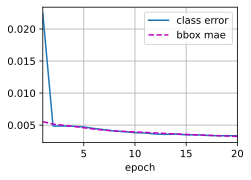

In [26]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

In [57]:
#预测目标
X = torchvision.io.read_image('/home/333.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [58]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

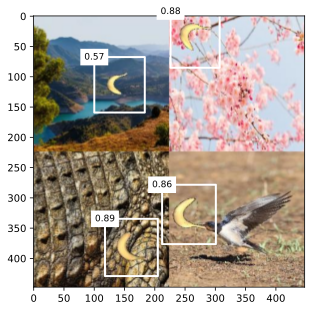

In [64]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.5)#拼接图片识别的精度还是xue微差点


##小结
* 单发多框检测是⼀种多尺度⽬标检测模型。基于基础⽹络块和各个多尺度特征块，单发多框检测⽣成不同数量和不同⼤小的锚框，并通过预测这些锚框的类别和偏移量检测不同⼤小的⽬标。
* 在训练单发多框检测模型时，损失函数是根据锚框的类别和偏移量的预测及标注值计算得出的。


#R-CNN系列（区域卷积神经网络）
##R-CNN
&emsp;&emsp;R-CNN首先从输⼊图像中选取若干提议区域（如锚框也是⼀种选取⽅法），并标注它们的类别和边界框（如偏移量）。然后，⽤卷积神经⽹络对每个提议区域进⾏前向计算以抽取其特征。
![R-CNN](http://pan.anderd.com/download/615dab93cbe8d5003f66edeb)
&emsp;&emsp;R-CNN包括以下四个步骤：
> 1. 对输入图像使用选择性搜索来选取多个高质量的提议区域。这些提议区域通常是在多个尺度下选取的，并具有不同的形状和大小。每个提议区域都将被标注类别和真实边界框。
2. 选择一个预训练的卷积神经网络，并将其在输出层之前截断。将每个提议区域变形为网络需要的输入尺寸，并通过前向计算输出抽取的提议区域特征。
3. 将每个提议区域的特征连同其标注的类别作为一个样本。训练多个支持向量机对目标分类，其中每个支持向量机用来判断样本是否属于某一个类别。
4. 将每个提议区域的特征连同其标注的边界框作为一个样本，训练线性回归模型来预测真实边界框。

&emsp;&emsp;尽管R-CNN模型通过预训练的卷积神经网络有效地抽取了图像特征，但它的速度很慢.

##Fast R-CNN
![Fast-R-CNN](http://pan.anderd.com/download/615dae3ffee64f003fe50775)

&emsp;&emsp;Fast R-CNN对 R-CNN的主要改进之一，是仅在整张图象上执行卷积神经网络的前向计算。它的主要计算如下：
> 1. 与 R-CNN相比，Fast R-CNN用来提取特征的卷积神经网络的输入是整个图像，而不是各个提议区域（锚框）。此外，这个网络通常会参与训练。设输入为一张图像，将卷积神经网络的输出的形状记为$1×c×h_1×w_1$。
2. 假设选择性搜索生成了n个提议区域。这些形状各异的提议区域在卷积神经网络的输出上分别标出了形状各异的兴趣区域。然后，这些感兴趣的区域需要进一步抽取出形状相同的特征（比如指定高度$h_2和宽度w_2$），以便于连结后输出。为了实现这一目标，Fast R-CNN引入了兴趣区域 (RoI) 池化层：将卷积神经网络的输出和提议区域作为输入，输出连结后的各个提议区域抽取的特征，形状为$n×c×h_2×w_2$。
3. 通过全连接层将输出形状变换为n×d，其中超参数d取决于模型设计。
4. 预测n个提议区域中每个区域的类别和边界框。更具体地说，在预测类别和边界框时，将全连接层的输出分别转换为形状为n×q（q是类别的数量）的输出和形状为n×4的输出。其中预测类别时使用softmax回归。

&emsp;&emsp;在Fast R-CNN中提出的兴趣区域汇聚层与之前的汇聚层有所不同。在汇聚层中，我们通过设置池化窗口、填充和步幅的大小来间接控制输出形状。而兴趣区域汇聚层对每个区域的输出形状是可以直接指定的。

## Faster R-CNN
![Faster R-CNN](http://pan.anderd.com/download/615db020ed444f003f9f1c7f)

&emsp;&emsp;Faster R-CNN提出将选择性搜索替换为区域提议网络（region proposal network），从而减少提议区域的生成数量，并保证目标检测的精度。与Fast R-CNN相比，Faster R-CNN只将生成提议区域的方法从选择性搜索改为了区域提议网络，模型的其余部分保持不变。具体来说，区域提议网络的计算步骤如下：
> 1. 使用填充为1的3×3的卷积层变换卷积神经网络的输出，并将输出通道数记为c。这样，卷积神经网络为图像抽取的特征图中的每个单元均得到一个长度为c的新特征。
2. 以特征图的每个像素为中心，生成多个不同大小和宽高比的锚框并标注它们。
3. 使用锚框中心单元长度为c的特征，分别预测该锚框的二元类别（含目标还是背景）和边界框。
4. 使用非极大值抑制，从预测类别为目标的预测边界框中移除相似的结果。最终输出的预测边界框即是兴趣区域汇聚层所需的提议区域。

## Mask R-CNN
![Mask R-CNN](http://pan.anderd.com/download/615db11a22eebc003fe58f08)

&emsp;&emsp;如果在训练集中还标注了每个目标在图像上的像素级位置，那么Mask R-CNN能够有效地利用这些详尽的标注信息进一步提升目标检测的精度.

> Mask R-CNN是基于Faster R-CNN修改而来的。具体来说，Mask R-CNN将兴趣区域汇聚层替换为了兴趣区域(RoI)对齐层，使用双线性插值（bilinear interpolation）来保留特征图上的空间信息，从而更适于像素级预测。兴趣区域对齐层的输出包含了所有与兴趣区域的形状相同的特征图。它们不仅被用于预测每个兴趣区域的类别和边界框，还通过额外的全卷积网络预测目标的像素级位置。

##小结
* R-CNN 对图像选取若干提议区域（锚框），使用卷积神经网络对每个提议区域执行前向计算以抽取其特征，然后再用这些特征来预测提议区域的类别和边界框。

* Fast R-CNN 对 R-CNN 的一个主要改进：只对整个图像做卷积神经网络的前向计算。它还引入了兴趣区域汇聚层，从而为具有不同形状的兴趣区域抽取相同形状的特征。

* Faster R-CNN 将 Fast R-CNN 中使用的选择性搜索替换为参与训练的区域提议网络，这样后者可以在减少提议区域数量的情况下仍保证目标检测的精度。

* Mask R-CNN 在 Faster R-CNN 的基础上引入了一个全卷积网络，从而借助目标的像素级位置进一步提升目标检测的精度。